# DSFB 2019 Project - Team 3: Solutions

Team members:
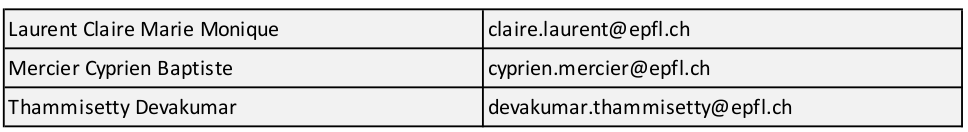

## IMPORTS

Here are a bunch of libraries that you may need to use...

In [80]:
import numpy  as np
import pandas as pd

import itertools
import random
import math  
import copy

import pandas_profiling

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier

# Supporting functions from scikit-learn
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import export_graphviz
from sklearn.decomposition   import PCA

# for text processing
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Set a seed for replication
SEED = 1  # Use this anywhere a stochastic function allows you to set a seed

# Additional imports
import missingno as msno
from sklearn.preprocessing import StandardScaler

In [2]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx")
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

# Quick look at the data and observations

In [3]:
df_learn.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 47 columns):
Unnamed: 0            3330 non-null int64
closeDay1             3215 non-null float64
offerPrice            3330 non-null float64
rf                    3057 non-null object
egc                   3330 non-null bool
html                  3330 non-null bool
patRatio              2055 non-null float64
city                  3329 non-null object
issuer                3330 non-null object
highTech              3330 non-null bool
age                   3148 non-null float64
exchange              3330 non-null object
year                  3330 non-null int64
industryFF5           3330 non-null object
industryFF12          3330 non-null object
industryFF48          3330 non-null object
nUnderwriters         3330 non-null int64
sharesOfferedPerc     3068 non-null float64
totalProceeds         3330 non-null int64
manager               3330 non-null object
investmentReceived    1830 non-null fl

**Comments**: We observe that there 47 columns out of which 39 are numeric/bool and 8 are text type. We also notice that there are some missing data in many fields. 

Now we look at the detailed profile of the dataFrame using pandas profiling. (The report is provided in HTML along with the submission. Observations related to the report are given below).

In [4]:
#file.profile_report()
profile = pandas_profiling.ProfileReport(df_learn)
#profile.to_file(outputfile='learn_data_profile_report.html')

**Observations from the profile report**

* Presence of missing values (Either drop or process the missig fileds)
* High correlation among 5 fields (May be ignored or Use PCA to reduce the dimentionality)
* Different scales, ranging from 0 to 1e9. (Need to normalize the data)
* Missing outcome: offerPrice(3.5%) and closeDay1(3.5%). Since there is no outcome, it may not be useful to use this data, may be dropped.
* Only 22% of the companies are marked emerging growth companies. (Possibility of bias?)
* Most of the companies are listed in NASDAQ(2368), followed by NYSE(895)
* Data is present from 1996 to 2018 (More data in the late 90s, but data is well spread across years)
* Five fields that are skewed (totalProceeds, InvestmentReceived, commonEquity1, totalRevenue, nPatents)
* 19 fileds out of 47 have missing entries. Highest missing entries in investmentReceived(45%) followed by nExecutives, priorFinancing, nVCs, patRatio, managementFee(32.9%) in descending order

In [5]:
# Profile report for the prediction data
profile = pandas_profiling.ProfileReport(df_predict)
#profile.to_file(outputfile='predict_data_profile_report.html')

In [9]:
data = copy.copy(df_learn)

We do exploratory analysis of the data and missing fields in the cells below

Missing data dristribution across various fields is shown below

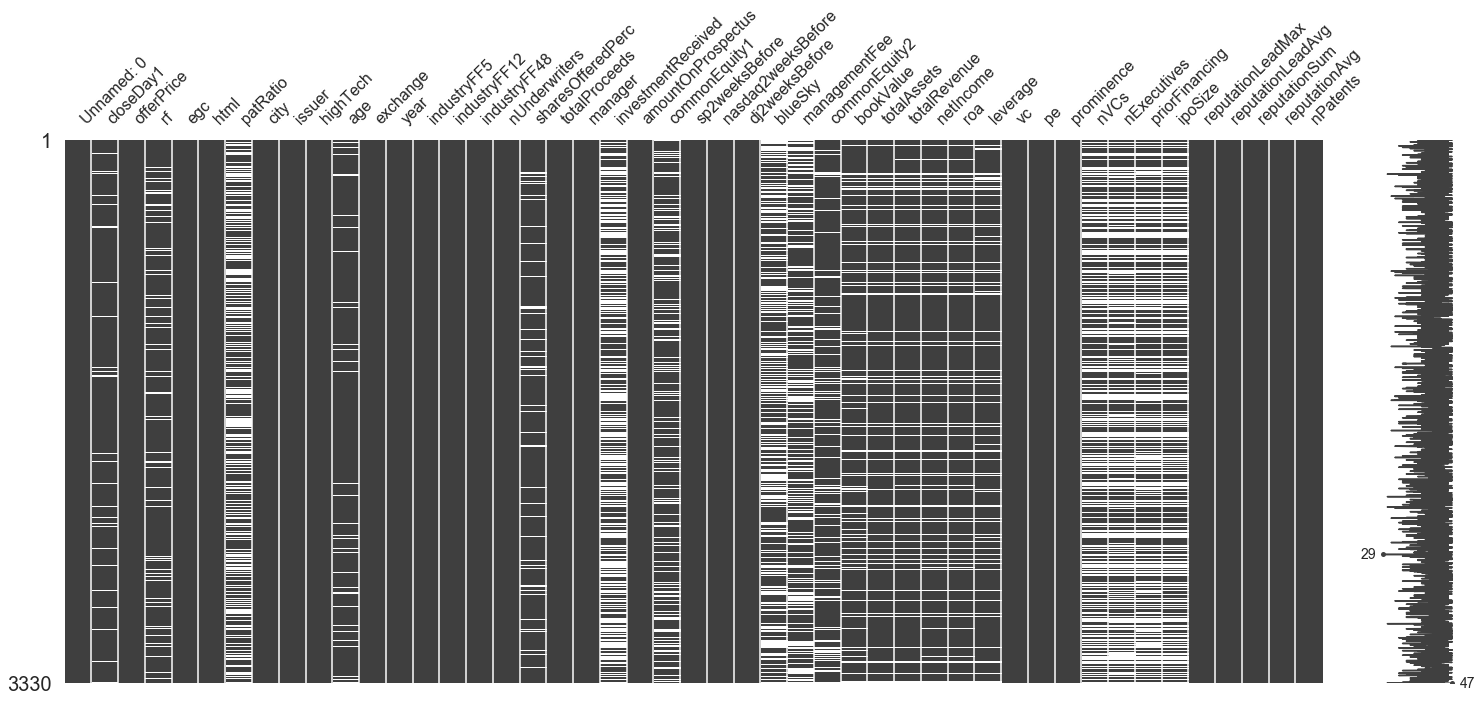

In [22]:
msno.matrix(data)

**Comment** : Write what the following cell does

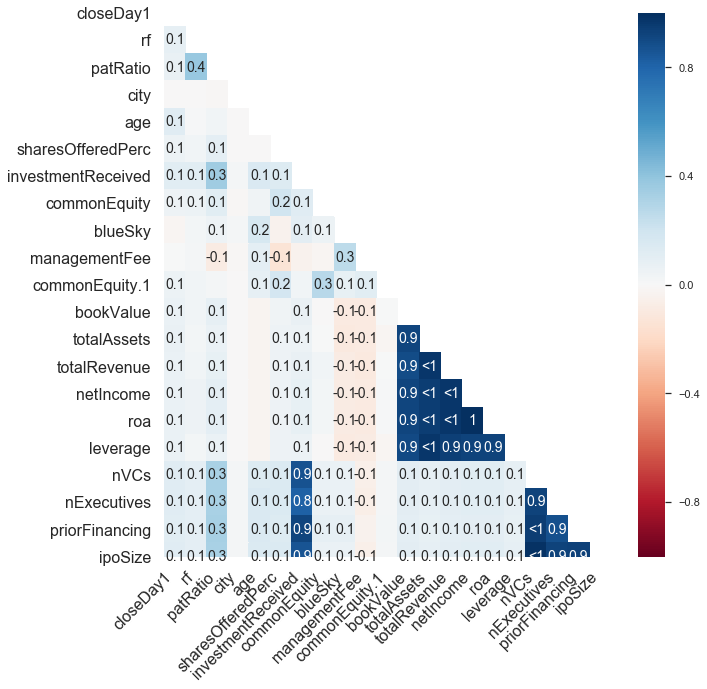

In [10]:
incomplete = data.columns[data.isnull().any()].tolist()
msno.heatmap(data[incomplete], figsize=(10,10))

**Comment**: The following cell shows the correlation among the datafields.

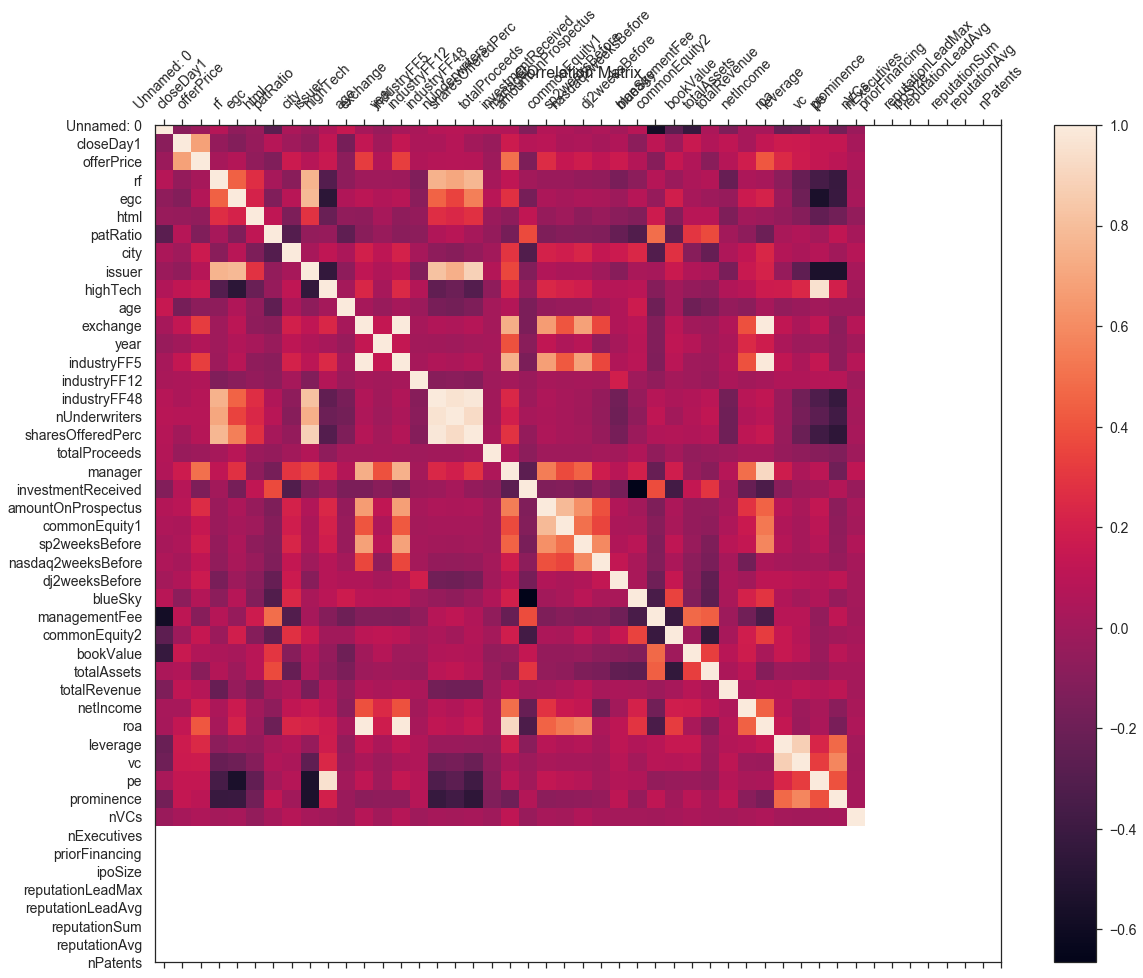

In [23]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**Observations**: We notice that most of the fields are weakly correlated. However, there are few features that has strong positive and negative correlations.

In [24]:
df_learn['exchange'].value_counts()

NASDQ    2368
NYSE      895
AMEX       67
Name: exchange, dtype: int64

In [25]:
df_learn['industryFF5'].value_counts()

Business Equipment, Telephone and Television Transmission                                         1122
Other                                                                                              898
Healthcare, Medical Equipment, and Drugs                                                           621
Consumer Durables, NonDurables, Wholesale, Retail, and Some Services (Laundries, Repair Shops)     393
Manufacturing, Energy, and Utilities                                                               296
Name: industryFF5, dtype: int64

In [26]:
df_learn['industryFF12'].value_counts().head()

Business Equipment -- Computers, Software, and Electronic Equipment    945
Healthcare, Medical Equipment, and Drugs                               621
Finance                                                                483
Other                                                                  462
Wholesale, Retail, and Some Services (Laundries, Repair Shops)         271
Name: industryFF12, dtype: int64

In [27]:
df_learn['industryFF48'].value_counts().head()

Business Services          845
Pharmaceutical Products    409
Trading                    221
Electronic Equipment       190
Retail                     158
Name: industryFF48, dtype: int64

**Comments**: Will probably need to only keep 1 of these, maybe FF12?


In [28]:
df_learn = df_learn.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

**Comments**: Age is the age of the firm. Should replace mising values by the mean? Are the zeros indicating new firms?

In [29]:
print(df_learn['age'].mean())
print(df_learn['age'].mode())

16.184561626429478
0    3.0
dtype: float64


In [30]:
len([w for w in df_learn['age'] if w>100])

53

**Comments**: Is it possible to have so much old companies?

In [31]:
print(df_learn['blueSky'].median(), df_learn['blueSky'].mean())

10000.0 12916.115884115885


**Comments**: Should do something with *blue sky* missing value: need to decide if really useful and, if it is, how to fill it. mean, median or mean between 1sr and 3rd quarter

# Part 1: data cleaning and preprocessing


In [51]:
processed_data = copy.copy(df_learn)

**Comment**: In the following cells, we replace or drop the null fields using appropriate logic for that perticular field

In [52]:
processed_data['age'].fillna(processed_data['age'].median(), inplace=True)

In [53]:
processed_data['blueSky'].fillna(processed_data['blueSky'].median(), inplace=True)

We decide to drop the data corresponding to missing or negative values of 'closeDay1' as this feature is very important and so replacing missing values may lead to huge misinterpretation. Moreover it corresponds to only 3.5% of the data


In [54]:
processed_data.dropna(subset=["closeDay1"], inplace=True)

**Comment** : We fill the null "Risk factor" field with ""

In [55]:
processed_data.rf.fillna("", inplace=True)

In [56]:
processed_data['patRatio'].fillna(processed_data['patRatio'].median(), inplace=True)

In [57]:
replace_mean = ["sharesOfferedPerc", "investmentReceived", "commonEquity1", "managementFee", "commonEquity2", "bookValue", "totalAssets", "totalRevenue", "netIncome", "roa", "leverage", "nVCs", "nExecutives", "priorFinancing", "ipoSize"]

In [58]:
processed_data[replace_mean] = processed_data[replace_mean].apply(lambda x: x.fillna(x.mean()),axis=0)

In [59]:
processed_data.shape

(3215, 47)

#data.profile_report()

Referring to the profile report generated, attached as HTML along with submission.

We can see that some features are highly correlated, so we will use PCA to remove the redundant features.

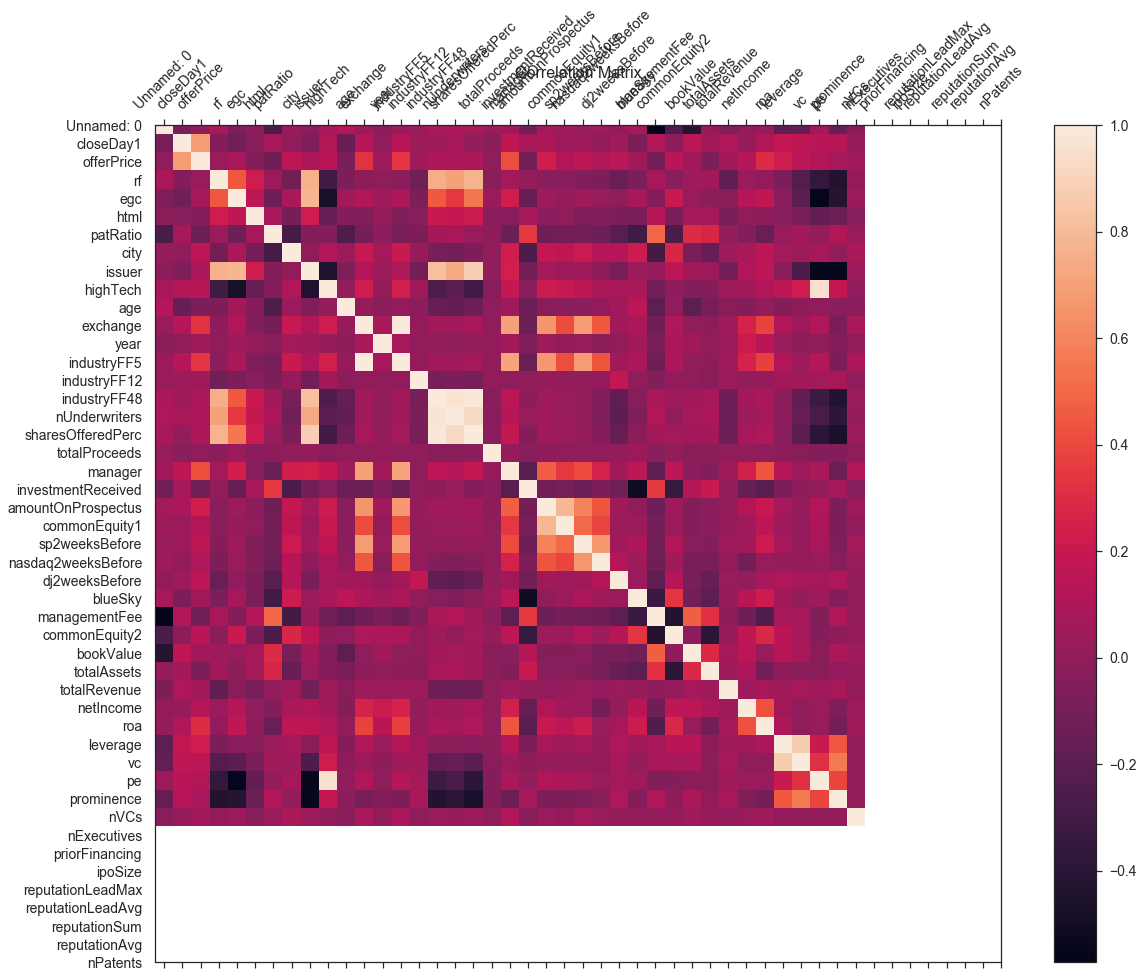

In [60]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(processed_data.corr(), fignum=f.number)
plt.xticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14, rotation=45)
plt.yticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The following cell shows that all the filed are pre-processed. Since there are no null fields. Also notice that the number of rows have reduced.

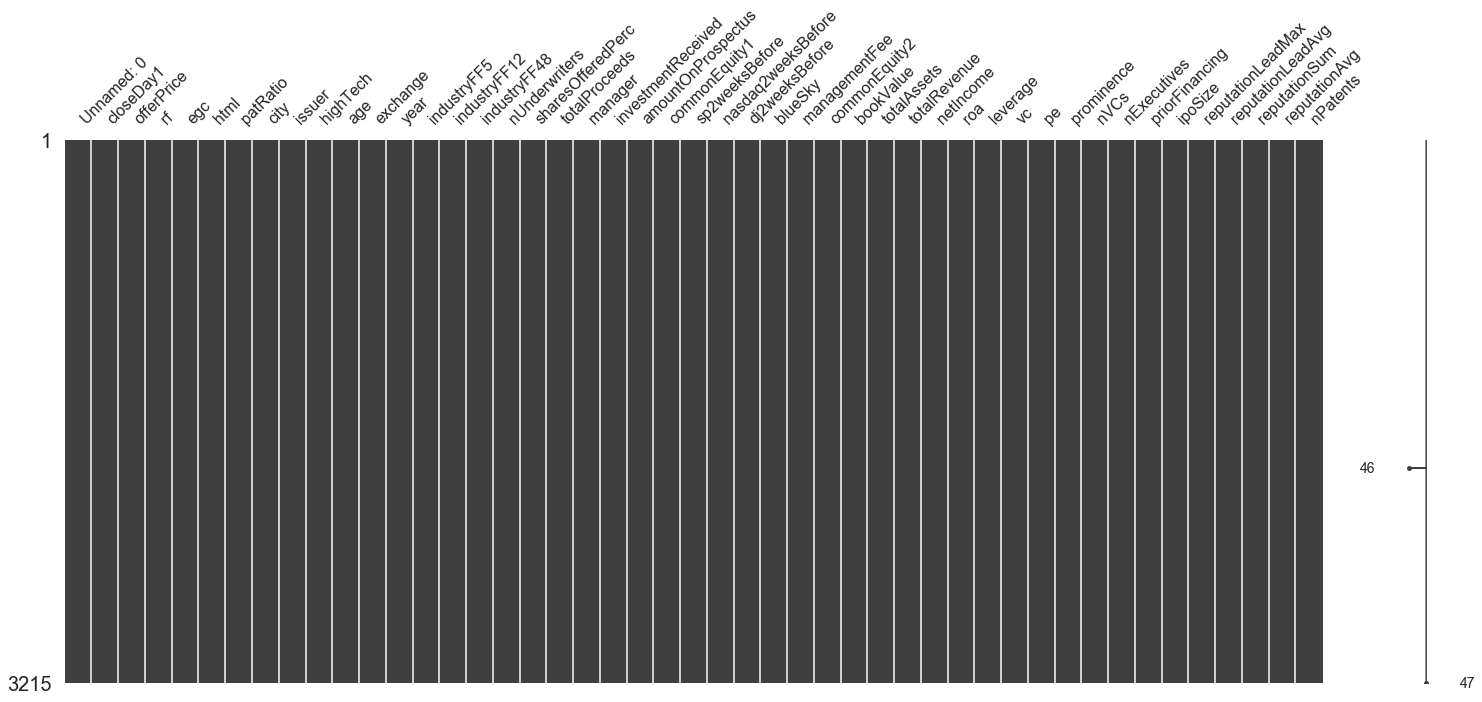

In [61]:
msno.matrix(processed_data)

In [62]:
processed_data.insert(3,"raisingPrice", 0, True)

In [63]:
processed_data=processed_data.reset_index()

In [64]:
for i in range (len(processed_data['closeDay1'])):
    if processed_data['closeDay1'][i]> processed_data['offerPrice'][i]:
        processed_data["raisingPrice"][i]= 1 
    else:
        processed_data["raisingPrice"][i]= 0 
    

In [65]:
y = np.array(processed_data['raisingPrice'])

# Part 1B: Text pre-process on Risk Factor

In [66]:
# Get English Stopwords from NLTK & Extend the stop word list
SW = stopwords.words('english')
SW.append('risk')
SW.append('factors')


In [67]:
stop_words = ['Co', '&', 'rf']

In [68]:
#looks how many percent of risk facor are NaN values
processed_data['rf'].isna().sum()/len(processed_data['rf'])

0.0

In [69]:
#file them with a blank
processed_data['rf'] = processed_data['rf'].fillna('')

In [70]:
# Define a custom function to clean punctuation from  given text
def clean_punctuation(txt):
    return str(txt).replace(",", " ").replace(".", " ").replace(":", " ").replace(";", " ").replace("?", " ").replace("!", " ").replace("\\", " ")


In [71]:
# Apply the function to clean the rf column
processed_data['rf'] = processed_data['rf'].apply(clean_punctuation)    
processed_data['rf'].head(1)

0    RISK FACTORS You should carefully consider the...
Name: rf, dtype: object

In [72]:
# Define a custom function to clean some given text
def clean_re(txt):
    txt = re.sub("[+]", " ", txt)
    txt = re.sub("[&]", " ", txt)
    txt = re.sub("\s \s", " ", txt)
    txt = re.sub("\s \s \s", " ", txt)
    return txt

In [73]:
# Apply clean_re() to all features
processed_data['rf'] = processed_data['rf'].apply(clean_re)    
processed_data['rf'].head(1)

0    RISK FACTORS You should carefully consider the...
Name: rf, dtype: object

In [74]:
# Define custom function to remove stopwords
def clean_sw(txt):
    li = list(txt.lower().split(" "))
    txt = [word for word in li if word not in SW]
    return ' '.join(txt)

In [75]:
# Apply function to remove stopwords
processed_data['rf'] = processed_data['rf'].apply(clean_sw)    
processed_data['rf'].head(1)

0    carefully consider following information conta...
Name: rf, dtype: object

In [76]:
# Define custom function to wrap simple_preprocess() from gensim
def sp(txt):
    return simple_preprocess(txt)

In [77]:
# Apply simple_preprocess() to all features
processed_data['rf'] = processed_data['rf'].apply(sp)    
processed_data['rf'].head(1)

0    [carefully, consider, following, information, ...
Name: rf, dtype: object

In [78]:
#nltk.download('wordnet') #downloading wordnet to use lemmatizer
lmtz=nltk.stem.WordNetLemmatizer()
# Write a lemmatization function based on nltk.stem.WordNetLemmatizer()
def lemmatiz(txt):
    return [lmtz.lemmatize(mot) for mot in txt]

In [79]:
# Apply lemmatize_text() to all features  
processed_data['rf'] = processed_data['rf'].apply(lemmatiz)    
processed_data['rf'].head(1)

0    [carefully, consider, following, information, ...
Name: rf, dtype: object

# Part 2: Feature extraction

Choose most relevant features for each of the model and justification

Logit : 

Baseline : 

Linear :

Knn:

Kmeans :

SVm:

Decision trees:

Random forests:

Splines:

In [81]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

# Part 3: Feature reduction

Reduce features using PCA

In [85]:
# Select features for PCA
data_pca = processed_data.select_dtypes([np.number])
data_pca.columns

Index(['index', 'Unnamed: 0', 'closeDay1', 'offerPrice', 'raisingPrice',
       'patRatio', 'age', 'year', 'nUnderwriters', 'sharesOfferedPerc',
       'totalProceeds', 'investmentReceived', 'amountOnProspectus',
       'commonEquity1', 'sp2weeksBefore', 'nasdaq2weeksBefore',
       'dj2weeksBefore', 'blueSky', 'managementFee', 'commonEquity2',
       'bookValue', 'totalAssets', 'totalRevenue', 'netIncome', 'roa',
       'leverage', 'prominence', 'nVCs', 'nExecutives', 'priorFinancing',
       'ipoSize', 'reputationLeadMax', 'reputationLeadAvg', 'reputationSum',
       'reputationAvg', 'nPatents'],
      dtype='object')

In [82]:
# Standardize ALL features
sc = StandardScaler()
X_std = sc.fit_transform(X)

ValueError: could not convert string to float: 'Business Equipment -- Computers, Software, and Electronic Equipment'

In [2]:
# Project features and find max components
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X_std)

# Explore and print out results for the relationship between AUC and the number of PCA Component Features
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('pca', PCA()))
estimators.append(('model', LogisticRegression()))
pipeline = Pipeline(estimators)

results = []
for c in range(1,28):
    pipeline.set_params(pca__n_components=c)
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml1 = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append( (auc_lml1, c)  )

df_auc_vs_pca = pd.DataFrame(results, columns=['AUC', 'no of PCA components'])

df_auc_vs_pca

NameError: name 'PCA' is not defined

# Part 4: Training, tuning, and testing of each model

Select appropriate features for each model

pipelining and hyper-parameter tunining (as appropriate)

baseline model comparisons

advanced model comparisons between different model typre

ensembles

descriptions and explanations of which model is best for each predicition problem

discussion of additional tasks or improvements that might boost performance

## A. Baseline model

In [27]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [28]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [29]:
#Look at the most commonly predicted outcome
most_frequent_outcome = data["raisingPrice"].value_counts().idxmax()
print('Most frequent outcome =', most_frequent_outcome)

Most frequent outcome = 1


### Train the model

In [30]:
y_hat_baseline = [most_frequent_outcome for v in y_test]
pd.Series(y_hat_baseline).value_counts()

1    643
dtype: int64

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## B. Linear model

In [149]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [150]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## C. Logit model

In [151]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [152]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## D. KNN

In [153]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [154]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [1]:
# Person 2 works on this

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## E. Decision trees

In [155]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [156]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## F. Random forests

In [157]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [158]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## G. SVM

In [159]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [160]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## H. Splines

In [161]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [162]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## I. CNN, RNN etc

In [163]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [164]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

# Part 5: Encembles

Ensemble modeling is a process where multiple diverse base models are used to predict an outcome. ... Even though the ensemble model has multiple base models within the model, it acts and performs as a single model. Most of the practical data science applications utilize ensemble modeling techniques.

# Part 6: Prediction

Prediction based on the predict xls features for each of P1 to P9

For each prediction, be sure to also show appropriate evaluation metrics in your Jupyter notebook. Show the standard metrics presented in class, but also the custom metrics given to you for problems 7, 8, and 9.

Commit and push your predictions (along with your final jupyter notebook file) as part of your project repository.

In [165]:
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

In [166]:
df_pred_final = copy.copy(df_predict)

## Prediction P1

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use all data from the dataset except for the rf variable (i.e., risk factors).


In [167]:
data = copy.copy(df_predict)

In [168]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [169]:
# df_pred_final.P1 = your prediction

## Prediction P2

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use only the rf (i.e., risk factors), year, and industryFF12 variables for this prediction task. You may, however, perform additional text analysis of the rf variable.


In [170]:
data = copy.copy(df_predict)

In [171]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [172]:
# df_pred_final.P2 = your prediction

For all remaining problems, you may use any or all of the features.

## Prediction P3

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price.


In [173]:
data = copy.copy(df_predict)

In [174]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [175]:
# df_pred_final.P3 = your prediction

## Prediction P4

    Predict whether the closing price at the end of the first day of trading will go up by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).

In [176]:
data = copy.copy(df_predict)

In [177]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [178]:
# df_pred_final.P4 = your prediction

## Prediction P5

    Predict whether the closing price at the end of the first day of trading will go down by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).


In [179]:
data = copy.copy(df_predict)

In [180]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [181]:
# df_pred_final.P5 = your prediction

## Prediction P6

    Predict the share price at the end of the first day.


In [182]:
data = copy.copy(df_predict)

In [183]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [184]:
# df_pred_final.P6 = your prediction

For the remaining problems, provide a predicted probability (expressed as a number from 0 to 100) that the stated event will happen.
## Prediction P7

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 5% from the original offer price.

Scoring Metric for P7: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score of p * p (i.e., the square of your predicted probability for that event) will be assessed. For predictions where the event turns out to be TRUE, a score of (100 - p) * (100 - p) will be assessed (i.e., the square of 100 minus your predicted probability for that event). Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, then the score for that observation would equal 4,900 (70 * 70 = 4,900); but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 900 (100 - 70 = 30, and 30 * 30 = 900).

In [185]:
data = copy.copy(df_predict)

In [186]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [187]:
# df_pred_final.P7 = your prediction

## Prediction P8

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 50% from the original offer price.

Scoring Metric for P8: Same scoring metric as P7 above. Attempt to tune you prediction model(s) accordingly.

In [188]:
data = copy.copy(df_predict)

In [189]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [190]:
# df_pred_final.P8 = your prediction

## Prediction P9

    Predict the probability that the closing price at the end of the first day of trading will go down (the "positive" case, coded as 1) or not (coded as 0) by more than 10% from the original offer price.

Scoring Metric for P9: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score equal to p will be assessed. For predictions where the event turns out to be TRUE, a score of 2 * (100 - p) will be assessed. Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, the score for that observation would equal 70; but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 2 * (100 - 70) = 60.

In [191]:
data = copy.copy(df_predict)

In [192]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [103]:
# df_pred_final.P9 = your prediction